<a href="https://colab.research.google.com/github/fabiorfc/DATASUS/blob/master/UNIFESP_HSD/Avalia%C3%A7%C3%A3o_An%C3%A1lise_explorat%C3%B3ria_de_dados_e_Fundamentos_de_estat%C3%ADstica.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Análise de dados**

**Aluno:** Fábio Ricardo Ferreira correa
****

## Resumo
Neste trabalho, foram utilizados dados dos Sistema de Informação de Nascidos vivos do estado de São Paulo informados no ano de 2017 (SINASC SP 2017).
O escopo deste trabalho restriugiu-se ao estudos de associação entre à ocorrência de ao menos um filho morto e as variáveis:
*   Quantidades de semanas de gestação
*   APGAR mensurado no primeiro minuto de vida da criança
*   APGAR mensurado no quinto minuto de vida da criança
*   Idade da mãe
*   Quantidades de consultas pré-natal
*   Local de nascimento

As análises deste estudo podem ser dividas em **Análise Univariada** e **Análise Bivariada**. 

Na primeira parte foi avaliada as estatísticas descritivas da base de dados, na qual foram verificadas algumas inconsistência nos dados e posterior eliminação das referentes linhas.

A segunda parte do estudo, se preocupou em avaliar a relação entre a ocorrência de ao menos um filho morto com as demais variáveis.

# 1) **Preparando o Ambiente de análise dos dados**

Esta primeira sessão foi utilizada para o preparamento do ambiente e tratamentos dos dados do SINASC.

Os dados utilizados neste estudo podem ser encontrado nos seguintes endereços

**Acesso aos dados do DATASUS**: http://www2.datasus.gov.br/DATASUS/index.php?area=0901

**Acesso ao repositório completo**: ftp://ftp.datasus.gov.br/dissemin/publicos

## 1.1) Instalando o pysus e o dbfread

In [0]:
!pip install pysus

## 1.2) Importando as libraries


In [0]:
from pysus.utilities.readdbc import read_dbc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.discrete.discrete_model as sm
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score,roc_curve

## 1.3) Caregando os dados no formato .dbf e salvando em .csv

**Observação**: A ideia de ler os dados em formato *.dbf* e salvar em *.csv* é poder realizar a leitura dos dados em diferentes momentos de forma mais rápida.

In [0]:
#dados = read_dbc('DNSP2017.dbc', encoding='iso-8859-1')
#dados.to_csv('DNSP2017.csv', index=False)

## 1.5) Carregando os dados no formato .csv

In [0]:
dados = pd.read_csv('DNSP2017.csv')
dados.head()

,NUMERODN,CODINST,ORIGEM,NUMERODV,PREFIXODN,CODESTAB,CODMUNNASC,LOCNASC,IDADEMAE,ESTCIVMAE,ESCMAE,CODOCUPMAE,QTDFILVIVO,QTDFILMORT,CODMUNRES,GESTACAO,GRAVIDEZ,PARTO,CONSULTAS,DTNASC,HORANASC,SEXO,APGAR1,APGAR5,RACACOR,PESO,IDANOMAL,DTCADASTRO,CODANOMAL,NUMEROLOTE,VERSAOSIST,DTRECEBIM,DIFDATA,DTRECORIGA,NATURALMAE,CODMUNNATU,CODUFNATU,ESCMAE2010,SERIESCMAE,DTNASCMAE,RACACORMAE,QTDGESTANT,QTDPARTNOR,QTDPARTCES,IDADEPAI,DTULTMENST,SEMAGESTAC,TPMETESTIM,CONSPRENAT,MESPRENAT,TPAPRESENT,STTRABPART,STCESPARTO,TPNASCASSI,TPFUNCRESP,TPDOCRESP,DTDECLARAC,ESCMAEAGR1,STDNEPIDEM,STDNNOVA,CODPAISRES,TPROBSON,PARIDADE,KOTELCHUCK
0,71507302,MPA1501400001,1,0.0,30.0,2340992.0,150140,1,18,1.0,4.0,999992.0,NaN,NaN,351840,5.0,1.0,2.0,4,17062017,1905.0,1,8.0,9.0,4.0,3580.0,2.0,3072017,NaN,20170027,3.2.01,29082017,73,NaN,815.0,150140.0,15.0,3.0,3.0,30121998.0,4.0,NaN,NaN,NaN,21.0,12092016.0,39.0,8.0,16.0,1.0,1.0,2.0,9.0,1.0,5.0,0.0,19062017.0,6.0,0.0,1.0,NaN,1.0,0.0,5.0
1,72381521,ETO1721000001,1,8.0,30.0,2786109.0,170950,1,13,1.0,3.0,999991.0,0.0,0.0,350900,4.0,1.0,1.0,2,17012017,1815.0,1,8.0,10.0,4.0,1936.0,2.0,13092018,NaN,20180031,3.2.00,17092018,608,NaN,821.0,211130.0,21.0,2.0,6.0,27032003.0,4.0,0.0,0.0,0.0,22.0,1062016.0,32.0,8.0,3.0,7.0,2.0,1.0,3.0,1.0,2.0,3.0,17012017.0,3.0,0.0,1.0,NaN,6.0,0.0,2.0
2,72380744,ETO1721000001,1,4.0,30.0,2755157.0,172100,1,17,5.0,4.0,999992.0,0.0,0.0,355220,5.0,1.0,2.0,4,6032017,446.0,1,9.0,10.0,4.0,3370.0,2.0,9032017,NaN,20170021,3.2.00,10042017,35,NaN,817.0,171820.0,17.0,3.0,3.0,5041999.0,4.0,0.0,0.0,0.0,NaN,NaN,39.0,9.0,7.0,2.0,1.0,2.0,1.0,1.0,NaN,3.0,6032017.0,6.0,0.0,1.0,NaN,2.0,0.0,5.0
3,71588260,MMA2106750001,1,2.0,30.0,2455463.0,210675,1,19,1.0,4.0,NaN,1.0,0.0,350950,5.0,1.0,2.0,3,25032017,235.0,2,9.0,10.0,4.0,3050.0,2.0,13032018,NaN,20180006,3.2.01,10042018,381,NaN,835.0,350950.0,35.0,3.0,2.0,7081997.0,4.0,1.0,0.0,1.0,NaN,29062016.0,38.0,8.0,6.0,9.0,1.0,2.0,9.0,1.0,5.0,4.0,27032017.0,5.0,0.0,1.0,NaN,5.0,1.0,2.0
4,71564068,MMA2112300001,1,4.0,30.0,6553567.0,211230,1,24,1.0,4.0,811705.0,2.0,0.0,355030,5.0,1.0,2.0,4,16022017,1010.0,1,10.0,10.0,4.0,3900.0,2.0,20022017,NaN,20170003,3.2.01,20022017,4,NaN,835.0,355030.0,35.0,3.0,2.0,26011993.0,4.0,2.0,1.0,1.0,NaN,1052016.0,41.0,8.0,8.0,1.0,1.0,2.0,2.0,1.0,5.0,5.0,17022017.0,5.0,0.0,1.0,NaN,5.0,1.0,5.0


# 2) **Explorando a base de dados**

## 2.1) Variáveis selecionadas para realização dos estudo

As variáveis analisadas neste trabalho serão

*   **SEMAGESTAC**: Semanas de gestação
*   **APGAR1**: Apgar mensurado no primeiro minuto de vida do recém nascido
*   **APGAR5**: Apgar mensurado no quinto minuto de vida do recém nascido
*   **IDADEMAE**: Idade da mãe
*   **LOCNASC**: Local de Nascimento, sendo:
  1.   Hospital
  2.   Outro Estabelecimento de Saúde
  3.   Domicílio
  4.   Outros
*   **CONSULTAS**: Número de consultas Pré-natal
*   **QTDFILMORT**: Quantidade de filhos mortos


## 2.2) Natureza das variáveis

O conjunto de variáveis selecionadas é composto por 6 do tipo Quantitativa  e 1 Qualitativa. Especificamente, podemos classificar como:
*   **Qualitativa nominal**:
  *   **LOCNASC**: Local de Nascimento
*   **Quantitativa contínua**
  *   **SEMAGESTAC**
  *   **APGAR1**
  *   **APGAR5**
  *   **IDADEMAE**
*   **Quantitativa discreta**
  * **CONSULTAS**

In [0]:
# Seleção das variáveis de interesse
dados = dados[['SEMAGESTAC','APGAR1','APGAR5','IDADEMAE','LOCNASC','CONSULTAS','QTDFILMORT']]
dados.head()

,SEMAGESTAC,APGAR1,APGAR5,IDADEMAE,LOCNASC,CONSULTAS,QTDFILMORT
0,39.0,8.0,9.0,18,1,4,NaN
1,32.0,8.0,10.0,13,1,2,0.0
2,39.0,9.0,10.0,17,1,4,0.0
3,38.0,9.0,10.0,19,1,3,0.0
4,41.0,10.0,10.0,24,1,4,0.0


In [0]:
# Mapeamento do local de Nascimento
dados["LOCNASC"] = dados["LOCNASC"].map({1:"Hospital",2:"Outro Estabelecimento de Saúde",3:"Domicílio",4:"Outros"})

## 2.3) Criação de novas variáveis e tratamento da base

#### FLAG_FILHOS_MORTOS
Como o objetivo deste estudo é avaliar a associação das variáveis selecionadas com a Quantidade de Filhos Mortos, foi criada uma nova variável para do tipo **Qualitativa Nominal** de nome **FLAG_FILHOS_MORTOS** para a qual o valor 1, indica que houve ao menos um filho morto e 0, caso contrário. 

#### CICLO_DE_VIDA
O conceito dessa variável é separar a idade das mulheres em faixas, de acordo com o documento *Mulheres e Saúde: Evidências de hoje, agenda de amanhã*. As faixas são
*   Até os 18 anos.
*   De 18 aos 34 (inclusive)
*   Dos 34 aos 39 (inclusive)
*   Dos 39 aos 40 (inclusive)
*   Acima de e 40 (inclusive)

#### Exclusão de linhas com valores nulos
Para esta análise, foram excluídas as linhas nas quais havia um ou mais valores nulos para qualquer uma das variáveis selecionadas

### 2.3.1) Exclusão das linhas com algum valor nulo

In [0]:
# Verificação dos valores nulos no conjunto de dados
verificacao_dos_nulos = dados.isna().sum()
pd.DataFrame({"# nulos":verificacao_dos_nulos, "% Nulos":round(100*verificacao_dos_nulos/len(dados),2)})

,# nulos,% Nulos
SEMAGESTAC,585,0.34
APGAR1,562,0.33
APGAR5,519,0.30
IDADEMAE,0,0.00
LOCNASC,4,0.00
CONSULTAS,0,0.00
QTDFILMORT,2888,1.67


In [0]:
# Exclusão das linhas com valores nulos
base_inicial = len(dados) #Verificando o número de linhas da base inicial
dados.dropna(axis=0, inplace=True)
dados.reset_index(drop=True,inplace=True)

In [0]:
# Criação da Flag de filhos mortos
dados["FLAG_FILHOS_MORTOS"] = [1 if i>=1 else 0 for i in dados["QTDFILMORT"]]

In [0]:
# Criação da Categoria CICLO_DE_VIDA
faixas = ["-18]","]18 ; 34]","]34 ; 39]","]39 ; 40]","]40+"]
idades = [0,18,34,39,40,45]
dados["CICLO_DE_VIDA"] = pd.cut(dados["IDADEMAE"], bins=idades, labels=faixas)

In [0]:
# Print dos novos dados
dados.head()

,SEMAGESTAC,APGAR1,APGAR5,IDADEMAE,LOCNASC,CONSULTAS,QTDFILMORT,FLAG_FILHOS_MORTOS,CICLO_DE_VIDA
0,32.0,8.0,10.0,13,Hospital,2,0.0,0,-18]
1,39.0,9.0,10.0,17,Hospital,4,0.0,0,-18]
2,38.0,9.0,10.0,19,Hospital,3,0.0,0,]18 ; 34]
3,41.0,10.0,10.0,24,Hospital,4,0.0,0,]18 ; 34]
4,39.0,9.0,10.0,19,Hospital,4,0.0,0,]18 ; 34]


## 2.4) Análise Univariada dos dados

#### 2.4.1) **SEMAGESTAC**: Semanas de gestação

A partir dos gráficos de Histograma e Boxplot verifica-se que a maior concentração dados ocorre na faixa entre 35 e 40 semanas.

Percebe-se também, a incidência de alguns valores atípicos, configurando semanas gestacionais maiores que 40 e menores de 30.

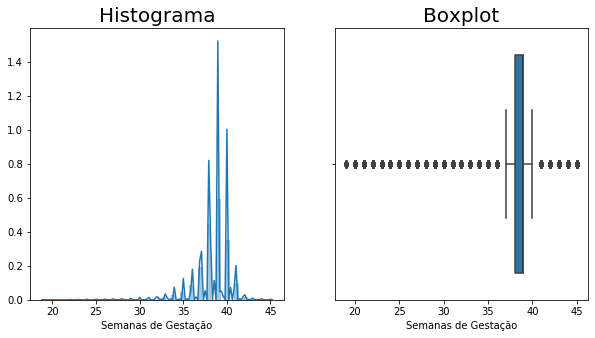

In [0]:
fig, axs = plt.subplots(1,2, figsize=(10,5))
sns.distplot(dados['SEMAGESTAC'], ax=axs[0]);axs[0].set_title('Histograma', fontsize=20);axs[0].set_xlabel('Semanas de Gestação')
sns.boxplot(x='SEMAGESTAC', data=dados, ax=axs[1]);axs[1].set_title('Boxplot', fontsize=20);axs[1].set_xlabel('Semanas de Gestação')
plt.show()

#### 2.4.2) **APGAR1**: Apgar mensurado no primeiro minuto de vida do recém nascido

Com base no histograma apresentado a seguir, verifica-se a ocorrência de valores de A**PGAR1** superior a 10. Com base na documentação apresentada, essas medidas não ultrapassam o valor 10. Sendo assim, foi aplicado um filtro nos dados para retirar as instâncias amostrais com **APGAR1** superior a 10.

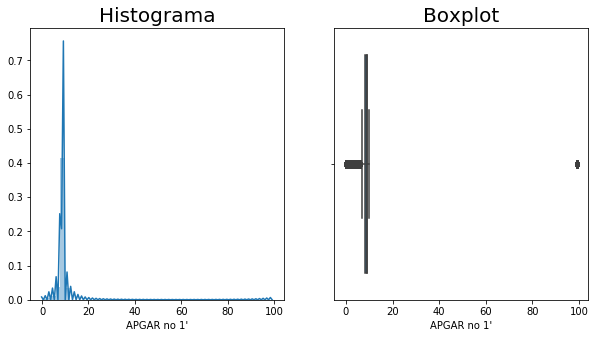

In [0]:
fig, axs = plt.subplots(1,2, figsize=(10,5))
sns.distplot(dados['APGAR1'], ax=axs[0]);axs[0].set_title('Histograma', fontsize=20);axs[0].set_xlabel("APGAR no 1'")
sns.boxplot(x='APGAR1', data=dados, ax=axs[1]);axs[1].set_title('Boxplot', fontsize=20);axs[1].set_xlabel("APGAR no 1'")
plt.show()

**Avaliação dos dados com APGAR1 maior que 10**

A partir da função *describe()* verifica-se que existem 121 instâncias amostras com valor de **APGAR1** superior a 10. Esses dados foram excluídos da análise.

In [0]:
dados[dados["APGAR1"]>10].describe()

,SEMAGESTAC,APGAR1,APGAR5,IDADEMAE,CONSULTAS,QTDFILMORT,FLAG_FILHOS_MORTOS
count,121.000000,121.0,121.000000,121.000000,121.000000,121.000000,121.000000
mean,35.528926,99.0,87.842975,26.950413,3.876033,0.380165,0.239669
std,5.267945,0.0,29.785345,6.430204,2.170139,0.829218,0.428657
min,19.000000,99.0,5.000000,15.000000,1.000000,0.000000,0.000000
25%,31.000000,99.0,99.000000,22.000000,3.000000,0.000000,0.000000
50%,38.000000,99.0,99.000000,28.000000,3.000000,0.000000,0.000000
75%,39.000000,99.0,99.000000,31.000000,4.000000,0.000000,0.000000
max,45.000000,99.0,99.000000,42.000000,9.000000,5.000000,1.000000


In [0]:
# Excluindo dados com APGAR1 maior que 10
dados_pos_APGAR1 = dados[dados["APGAR1"]<=10]
descricao_dos_filtros = ["Base Total", "Sem nulos", "APGAR1 <= 10"]
volume_das_bases = [base_inicial, len(dados), len(dados_pos_APGAR1)]
pd.DataFrame({"# de linhas":volume_das_bases,"% de linhas":np.array(volume_das_bases)/base_inicial}, index=descricao_dos_filtros)

,# de linhas,% de linhas
Base Total,172490,1.000000
Sem nulos,168579,0.977326
APGAR1 <= 10,168458,0.976625


**Avaliando os dados de APGAR1 da base filtrada**

APós a exclusão dos casos com **APGAR1** superior a 10, é possível ver a distribuição dos dados com maior clareza.

A maioria dos valores mensurados se concentram entre 8 e 10, configurando valores saudáveis de APGAR1. As crianças que apresentaram medidas inferiores a 6 são consideradas atípicas e apresentam dificuldade respiratória.

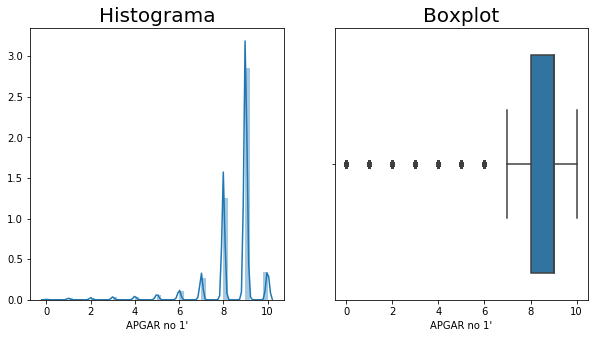

In [0]:
fig, axs = plt.subplots(1,2, figsize=(10,5))
sns.distplot(dados_pos_APGAR1['APGAR1'], ax=axs[0]);axs[0].set_title('Histograma', fontsize=20);axs[0].set_xlabel("APGAR no 1'")
sns.boxplot(x='APGAR1', data=dados_pos_APGAR1, ax=axs[1]);axs[1].set_title('Boxplot', fontsize=20);axs[1].set_xlabel("APGAR no 1'")
plt.show()

#### 2.4.3) **APGAR5**: Apgar mensurado no quinto minuto de vida do recém 

O mesmo tipo de observação atípica encontrada na análise do **APGAR1** foi verificada para o **APGAR5**.

Antes de fazer qualquer tipo de avaliação dos dados, foram excluídas as linhas com valores de **APGAR5** que superavam o valor 10.

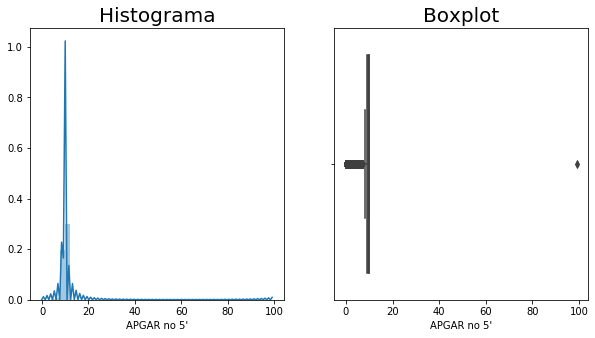

In [0]:
fig, axs = plt.subplots(1,2, figsize=(10,5))
sns.distplot(dados_pos_APGAR1['APGAR5'], ax=axs[0]);axs[0].set_title('Histograma', fontsize=20);axs[0].set_xlabel("APGAR no 5'")
sns.boxplot(x='APGAR5', data=dados_pos_APGAR1, ax=axs[1]);axs[1].set_title('Boxplot', fontsize=20);axs[1].set_xlabel("APGAR no 5'")
plt.show()

**Avaliação dos dados com APGAR5 > 10**

Apenas uma instância amostral apresentou **APGAR5** superior a 10.

In [0]:
dados_pos_APGAR1[dados_pos_APGAR1["APGAR5"]>10].describe()

,SEMAGESTAC,APGAR1,APGAR5,IDADEMAE,CONSULTAS,QTDFILMORT,FLAG_FILHOS_MORTOS
count,1.0,1.0,1.0,1.0,1.0,1.0,1.0
mean,40.0,9.0,99.0,20.0,4.0,0.0,0.0
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,40.0,9.0,99.0,20.0,4.0,0.0,0.0
25%,40.0,9.0,99.0,20.0,4.0,0.0,0.0
50%,40.0,9.0,99.0,20.0,4.0,0.0,0.0
75%,40.0,9.0,99.0,20.0,4.0,0.0,0.0
max,40.0,9.0,99.0,20.0,4.0,0.0,0.0


In [0]:
# Excluindo dados com APGAR1 maior que 10
dados_pos_APGAR5 = dados_pos_APGAR1[dados_pos_APGAR1["APGAR5"]<=10]
descricao_dos_filtros = ["Base Total", "Sem nulos", "APGAR1 <= 10", "APGAR5 <= 10"]
volume_das_bases = [base_inicial, len(dados), len(dados_pos_APGAR1), len(dados_pos_APGAR5)]
pd.DataFrame({"# de linhas":volume_das_bases,"% de linhas":np.array(volume_das_bases)/base_inicial}, index=descricao_dos_filtros)

,# de linhas,% de linhas
Base Total,172490,1.000000
Sem nulos,168579,0.977326
APGAR1 <= 10,168458,0.976625
APGAR5 <= 10,168457,0.976619


**Avaliando os dados filtrados**

Ao final da filtragem dos dados de **APGAR1** e **APGAR5**,  restaram 168.457 registros de um total de 172.490, representando uma redução de cerca de 2,4%

Avaliando os dados de **APGAR5** após a remoção dos valores inconsistêntes, verifica-se que grande parte da concentração dos dados está acima de 8, o que indica valores saudáveis de **APGAR**.

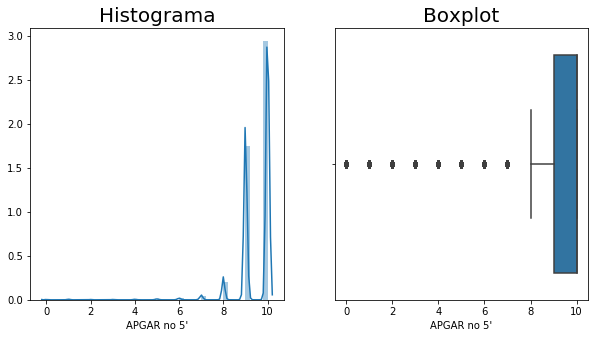

In [0]:
fig, axs = plt.subplots(1,2, figsize=(10,5))
sns.distplot(dados_pos_APGAR5['APGAR5'], ax=axs[0]);axs[0].set_title('Histograma', fontsize=20);axs[0].set_xlabel("APGAR no 5'")
sns.boxplot(x='APGAR5', data=dados_pos_APGAR5, ax=axs[1]);axs[1].set_title('Boxplot', fontsize=20);axs[1].set_xlabel("APGAR no 5'")
plt.show()

#### 2.4.4) **IDADEMAE**: Idade da mãe

Com base na curva de densidade e boxplot, percebe-se que grande parte das mães apresentam idades entre 20 e 35 anos. O primeiro gráfico dá sugestões de que os dados configuram uma distribuição normal. O segundo mostra alguns valores atípicos, de mulheres com idades avançadas.

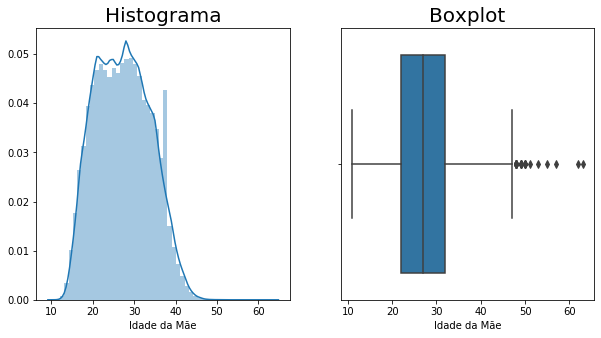

In [0]:
fig, axs = plt.subplots(1,2, figsize=(10,5))
sns.distplot(dados_pos_APGAR5['IDADEMAE'], ax=axs[0]);axs[0].set_title('Histograma', fontsize=20);axs[0].set_xlabel("Idade da Mãe")
sns.boxplot(x='IDADEMAE', data=dados_pos_APGAR5, ax=axs[1]);axs[1].set_title('Boxplot', fontsize=20);axs[1].set_xlabel("Idade da Mãe")
plt.show()

#### 2.4.5) **CONSULTAS**: Número de consultas Pré-natal

Quando avaliamos os dados de Consultas pré-natal, percebe-se grande maioria das mães realizaram 4 consultas pré-natal. Esse valor é tão presente no conjunto de dados que não foi possível nem configurar o gráfico de boxplot. Devido a isso, mães com 1, 2, 3 ou 9 consultas pré-natal foram definidas como atípicas pelo gráfico.

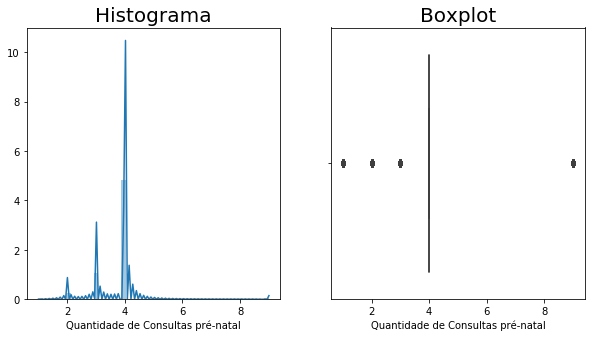

In [0]:
fig, axs = plt.subplots(1,2, figsize=(10,5))
sns.distplot(dados_pos_APGAR5['CONSULTAS'], ax=axs[0]);axs[0].set_title('Histograma', fontsize=20);axs[0].set_xlabel("Quantidade de Consultas pré-natal")
sns.boxplot(x='CONSULTAS', data=dados_pos_APGAR5, ax=axs[1]);axs[1].set_title('Boxplot', fontsize=20);axs[1].set_xlabel("Quantidade de Consultas pré-natal")
plt.show()

#### 2.4.6) **LOCNASC**: Local de Nascimento

Para essa análise, foram utilizadas um gráfico e uma tabela. O gráfico de barras mostra imensa maioria dos nascimentos ocorreram no hospital. Tal fato pode ser confirmado nos números apresentados na tabela, na qual verifica-se que apenas 0,5% dos nascimentos não ocorreram no hospital

In [0]:
tabela_agrupada_por_local_nasc = dados_pos_APGAR5.groupby("LOCNASC").count()["FLAG_FILHOS_MORTOS"]
tabela_agrupada_por_local_nasc = pd.DataFrame(tabela_agrupada_por_local_nasc)
tabela_agrupada_por_local_nasc['new'] = round(100*tabela_agrupada_por_local_nasc/len(dados_pos_APGAR5),2)
tabela_agrupada_por_local_nasc.columns = ['Freq. Absoluta','Freq. Relativa']
tabela_agrupada_por_local_nasc

,Freq. Absoluta,Freq. Relativa
LOCNASC,,
Domicílio,206,0.12
Hospital,167743,99.58
Outro Estabelecimento de Saúde,448,0.27
Outros,60,0.04


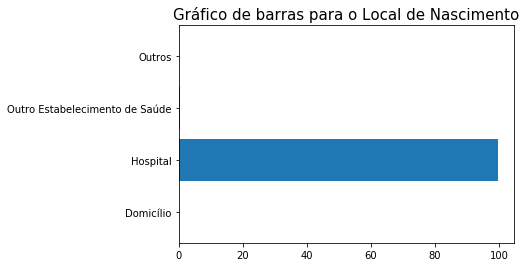

In [0]:
height = tabela_agrupada_por_local_nasc["Freq. Relativa"].values
bars = tabela_agrupada_por_local_nasc.index
plt.barh(np.arange(len(bars)), height)
plt.yticks(np.arange(len(bars)), bars)
plt.title('Gráfico de barras para o Local de Nascimento', fontsize=15)
plt.show()

###  2.4.7) **CICLO_DE_VIDA**: Ciclo de vida da mãe

Conforme já avaliado nos gráficos de Idade da Mãe, a variável que agrupa as mães em faixas etária confirma que apenas 25% das mulheres não têm idade entre 18 e 34 anos

In [0]:
tabela_agrupada_por_ciclo = dados_pos_APGAR5.groupby("CICLO_DE_VIDA").count()["FLAG_FILHOS_MORTOS"]
tabela_agrupada_por_ciclo = pd.DataFrame(tabela_agrupada_por_ciclo)
tabela_agrupada_por_ciclo['new'] = round(100*tabela_agrupada_por_ciclo/len(dados_pos_APGAR5),2)
tabela_agrupada_por_ciclo.columns = ['Freq. Absoluta','Freq. Relativa']
tabela_agrupada_por_ciclo

,Freq. Absoluta,Freq. Relativa
CICLO_DE_VIDA,,
-18],15779,9.37
]18 ; 34],126429,75.05
]34 ; 39],21249,12.61
]39 ; 40],1888,1.12
]40+,2989,1.77


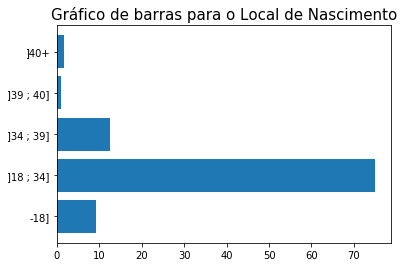

In [0]:
height = tabela_agrupada_por_ciclo["Freq. Relativa"].values
bars = tabela_agrupada_por_ciclo.index
plt.barh(np.arange(len(bars)), height)
plt.yticks(np.arange(len(bars)), bars)
plt.title('Gráfico de barras para o Local de Nascimento', fontsize=15)
plt.show()

### 2.4.8) **FLAG_FILHOS_MORTOS**: Volume de pacientes com ao menos 1 filho morto

A criação da *flag* de filhos mortos tem como objetivo, a geração de um modelo de classificação mediante regressão logística para avaliar qual das variáveis até atqui descritas melhor explica a ocorrência de filhos mortos e o quanto as mesma podem ajudar a predição deste evento.

Para este estudo, não foi utilizado o conceito de aprendizado de máquina. Logo, não a separação do conjunto de dados entre treinamento e teste, tampouco a técnica de balanceamento amostral para otimizar a estimativas dos *betas* da regressão. O objetivo da regressão foi o de, apenas, explorar o conjunto de dados.

Avaliando a tabela e o gráfico a seguir, nota-se que 18% das mães tiveram ao menos um filho morto

In [0]:
tabela_flag_filhos_mortos = dados_pos_APGAR5.groupby("FLAG_FILHOS_MORTOS").count()['QTDFILMORT']
tabela_flag_filhos_mortos = pd.DataFrame(tabela_flag_filhos_mortos)
tabela_flag_filhos_mortos['new'] = round(100*tabela_flag_filhos_mortos/tabela_flag_filhos_mortos.sum(),2)
tabela_flag_filhos_mortos.columns = ['Freq. Absoluta', 'Freq. Relativa']
tabela_flag_filhos_mortos.index = ['Sem Filhos mortos', 'Ao menos 1 filho morto']
tabela_flag_filhos_mortos

,Freq. Absoluta,Freq. Relativa
Sem Filhos mortos,138284,82.09
Ao menos 1 filho morto,30173,17.91


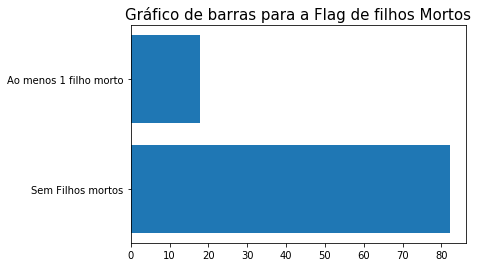

In [0]:
height = tabela_flag_filhos_mortos["Freq. Relativa"].values
bars = tabela_flag_filhos_mortos.index
plt.barh(np.arange(len(bars)), height)
plt.yticks(np.arange(len(bars)), bars)
plt.title('Gráfico de barras para a Flag de filhos Mortos', fontsize=15)
plt.show()

### 2.4.9) Finalização da análise bivariada

Nesta última etapa, foi instanciado um último objeto com os dados após todas as etapas de filtragem.

Ao término dessa etapa de análise univariada, restaram 168.457 registros de um total de 172.490, configurando redução de 2.4%

In [0]:
pd.DataFrame({"# de linhas":volume_das_bases,"% de linhas":np.array(volume_das_bases)/base_inicial}, index=descricao_dos_filtros)

,# de linhas,% de linhas
Base Total,172490,1.000000
Sem nulos,168579,0.977326
APGAR1 <= 10,168458,0.976625
APGAR5 <= 10,168457,0.976619


**Descrição da base final**
A partir da função *describe()* verifica-se que as variáveis apresentam pouca amplitude interquartil. 

Para o Campo **CONSULTAS** pelo menos 50% das mulheres tiveram 4 consultas pré-natal. A maioria dos partos ocorreram nos hospitais e a maioria das mães estão na faixa entre 18 e 34 anos.

In [0]:
# Instanciando o objeto final com o dados tratados
dados_tratados = dados_pos_APGAR5
dados_tratados.describe(include='all')

,SEMAGESTAC,APGAR1,APGAR5,IDADEMAE,LOCNASC,CONSULTAS,QTDFILMORT,FLAG_FILHOS_MORTOS,CICLO_DE_VIDA
count,168457.000000,168457.000000,168457.000000,168457.000000,168457,168457.000000,168457.000000,168457.000000,168334
unique,NaN,NaN,NaN,NaN,4,NaN,NaN,NaN,5
top,NaN,NaN,NaN,NaN,Hospital,NaN,NaN,NaN,]18 ; 34]
freq,NaN,NaN,NaN,NaN,167743,NaN,NaN,NaN,126429
mean,38.337196,8.453445,9.485643,27.238553,NaN,3.759850,0.228836,0.179114,NaN
std,2.115362,1.238465,0.825425,6.572332,NaN,0.711683,0.807790,0.383449,NaN
min,19.000000,0.000000,0.000000,11.000000,NaN,1.000000,0.000000,0.000000,NaN
25%,38.000000,8.000000,9.000000,22.000000,NaN,4.000000,0.000000,0.000000,NaN
50%,39.000000,9.000000,10.000000,27.000000,NaN,4.000000,0.000000,0.000000,NaN
75%,39.000000,9.000000,10.000000,32.000000,NaN,4.000000,0.000000,0.000000,NaN


## 2.5 Avaliando a influências das variáveis escolhidas à ocorrência de filhos mortos

### 2.5.1) Avaliando a associação entre as variáveis de entrada e a Flag de filhos mortos

Antes de ajustar uma regressão logística aos dados, foi feita uma análise descritiva, separando o conjunto de dados em dois grupos, um de mulheres com ao menos 1 filho morto e outro com zero filohs mortos. 
A avaliação entre a diferença das distribuições dos dados dos dois grupos foi feita mediante gráfico de boxplot.

#### *SEMAGESTAC*: Semanas de gestação

Começando pela diferença entre as distribuições das semanas de gestação, verifica-se que o grupo com zero filhos mortos apresenta boxplot pouco acima do grupo com ao menos um filho morto.

Como essa diferença é visual e pouco significativa, fica difícil verificar evidências que apontem associação entre a quantidade de semanas de gestação e a ocorrência de filhos mortos

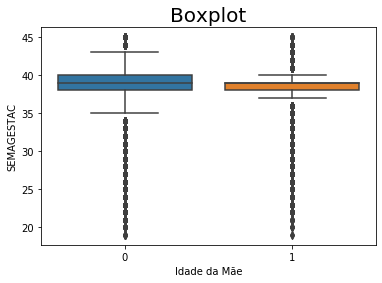

In [0]:
sns.boxplot(y='SEMAGESTAC', x='FLAG_FILHOS_MORTOS',data=dados_tratados)
plt.title('Boxplot', fontsize=20)
plt.xlabel("Idade da Mãe")
plt.show()

#### *APGAR1*: Apgar mensurado no primeiro minuto de vida do recém nascido

Comparando os valores de **APGAR** mensurados no primeiro minuto de vida, verifica-se quase nenhuma diferença entre as distribuições.

Segundo o gráfico de Boxplot, existe evidências de que os valores de APGAR mensurados no primeiro minuto, não têm associação com a ocorrência de filhos mortos.

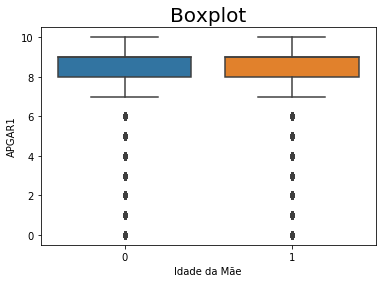

In [0]:
sns.boxplot(y='APGAR1', x='FLAG_FILHOS_MORTOS',data=dados_tratados)
plt.title('Boxplot', fontsize=20)
plt.xlabel("Idade da Mãe")
plt.show()

#### *APGAR5*: Apgar mensurado no primeiro minuto de vida do recém nascido

Com base no boxplot a seguir, verifica-se que também não existe diferença significativa entre os valores de APGAR5 para os grupos de filhos não mortos e mortos.

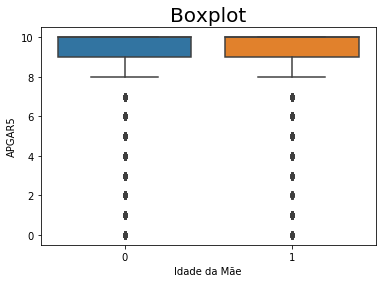

In [0]:
sns.boxplot(y='APGAR5', x='FLAG_FILHOS_MORTOS',data=dados_tratados)
plt.title('Boxplot', fontsize=20)
plt.xlabel("Idade da Mãe")
plt.show()

#### *IDADEMAE*: Idade da mãe

Para a variável Idade da mãe, percebe-se pouca diferença visual entre os boxplot dos grupos. As mulheres que tiveram ao menos 1 filhos morto apresentam Idade mediana, primeiro e terceiro quartis superiores ao de mulheres com nenhum filho morto. 

Essa diferença, apesar de pouco significativa pode ajudar a explicar a variável *FLAG_FILHOS_MORTOS*.

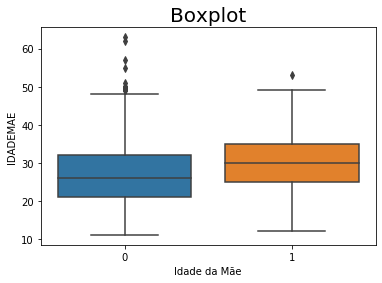

In [0]:
sns.boxplot(y='IDADEMAE', x='FLAG_FILHOS_MORTOS',data=dados_tratados)
plt.title('Boxplot', fontsize=20)
plt.xlabel("Idade da Mãe")
plt.show()

#### *CONSULTAS*: Número de consultas Pré-natal

A partir do gráfico de boxplot, percebe-se nenhuma diferença entre os numéro de consultas pré-natal para os grupos de mulheres.

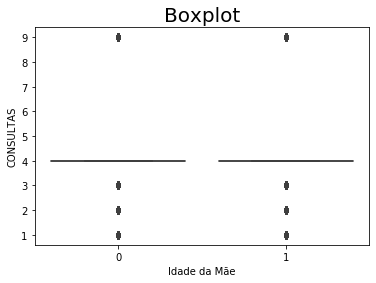

In [0]:
sns.boxplot(y='CONSULTAS', x='FLAG_FILHOS_MORTOS',data=dados_tratados)
plt.title('Boxplot', fontsize=20)
plt.xlabel("Idade da Mãe")
plt.show()

### 2.5.2) Avaliando a correlação entre as variáveis

Antes de ajustar uma regressão logística nos dados, foi feito uma análise de correlação entre as variáveis de entrada para minimizar problemas de multicolinearidade dos dados.

Como verificado na análise univariada, a maioria das mulheres tiveram seus partos no hospital (99,5%), a variável de local de nascimento foi previamente descartada.

Outra variável descarta foi de *faixa etária*, pois ela já está sendo representada pela *idade da mãe*


In [0]:
# Variáveis de entrada
X = dados_tratados[['SEMAGESTAC', 'APGAR1', 'APGAR5', 'IDADEMAE', 'CONSULTAS']]
y = dados_tratados['FLAG_FILHOS_MORTOS']

In [0]:
X.corr()

,SEMAGESTAC,APGAR1,APGAR5,IDADEMAE,CONSULTAS
SEMAGESTAC,1.000000,0.247049,0.253971,-0.058696,0.140247
APGAR1,0.247049,1.000000,0.699481,0.014083,0.049995
APGAR5,0.253971,0.699481,1.000000,0.009656,0.057324
IDADEMAE,-0.058696,0.014083,0.009656,1.000000,0.070006
CONSULTAS,0.140247,0.049995,0.057324,0.070006,1.000000


In [0]:
X.corr().style.background_gradient(cmap='coolwarm').set_precision(2)


,SEMAGESTAC,APGAR1,APGAR5,IDADEMAE,CONSULTAS
SEMAGESTAC,1,0.25,0.25,-0.059,0.14
APGAR1,0.25,1,0.7,0.014,0.05
APGAR5,0.25,0.7,1,0.0097,0.057
IDADEMAE,-0.059,0.014,0.0097,1,0.07
CONSULTAS,0.14,0.05,0.057,0.07,1


Avaliando o gráfico e a tabela de correlação entre as variáveis de entrada verificou-se alto valor de correlação entre **APGAR1** e **APGAR5**. Esse nível de correlação pode gerar confundimento no modelo de regressão logística. [(James, G 2013)](https://www.amazon.com.br/Introduction-Statistical-Learning-Applications-103/dp/1461471370)
Sendo assim, optou-se por excluir a variável **APGAR5**.

In [0]:
X = X.drop(columns = ['APGAR5'])
X.head()

,SEMAGESTAC,APGAR1,IDADEMAE,CONSULTAS
0,32.0,8.0,13,2
1,39.0,9.0,17,4
2,38.0,9.0,19,3
3,41.0,10.0,24,4
4,39.0,9.0,19,4


### 2.5.3) Ajustando a regressão logística

O ajuste da regressão logística aos dados foi feito utilizando todas as variáveis que restaram após a análise de correlação.
Com base nos *p-valores* apresentados na tabela de resumo da regressão, todas as variáveis foram ajustadas e são significativas.

In [0]:
model = sm.Logit(y, X_filtrado)
result = model.fit()
result.summary()

Optimization terminated successfully.
         Current function value: 0.454067
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:     FLAG_FILHOS_MORTOS   No. Observations:               168457
Model:                          Logit   Df Residuals:                   168452
Method:                           MLE   Df Model:                            4
Date:                Wed, 18 Dec 2019   Pseudo R-squ.:                 0.03400
Time:                        01:01:41   Log-Likelihood:                -76491.
converged:                       True   LL-Null:                       -79183.
Covariance Type:            nonrobust   LLR p-value:                     0.000
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
SEMAGESTAC    -0.0646      0.002    -30.067      0.000      -0.069      -0.060
APGAR1        -0.0229      0.005     -4.429      0.000      -0.033      -0.013
IDADEMAE       0.0683      0.001     70.211      0.000       0.066       0.070
CONSULTAS     -0.0291      0.009     -3.155      0.002      -0.047      -0.011
Hospital      -0.6724      0.068     -9.896      0.000      -0.806      -0.539
==============================================================================
"""

### 2.5.4) Verificando a qualidade do ajuste da regressão

Após o ajuste da regressão logística, foi utilizado um gráfico de AUC-ROC para avaliar a qualidade do ajuste.
Com base no gráfico e no valor de AUC=0,59, pode-se concluir que o que apesar de as variáveis ter sua significância no modelo, elas não conseguem explicar a ocorrência de filhos mortos muito melhor do que a taxa aleatória base de 0,50.

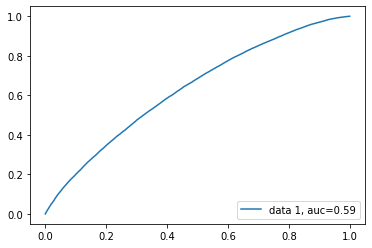

In [0]:
fpr, tpr, _ = roc_curve(y,result.predict())
auc = round(roc_auc_score(y,(result.predict()>=0.15)*1),2)

plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()